## Connect GoogleColab

## 一、載入相關套件

In [1]:
# 資料處理套件
import os
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns

In [2]:
# 設定顯示中文字體
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

In [3]:
# 深度學習模組套件
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils as np_utils
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 二、讀取資料

In [5]:
# 讀取資料集標籤檔
train_label = pd.read_csv("train.csv",encoding="utf8")
train_label.head()

,image_id,label
0,00002.jpg,C
1,00003.jpg,C
2,00004.jpg,B
3,00005.jpg,A
4,00007.jpg,A


In [6]:
# 串接圖片檔的路徑 & 讀取路徑中的圖片
train_pics_path = os.path.join("C1-P1_Train")
train_mango_fnames = os.listdir(train_pics_path)

In [7]:
# 檢視是否有讀取到圖片
print(train_mango_fnames[0])
print(train_mango_fnames[1])
print(train_mango_fnames[2])

00002.jpg
00003.jpg
00004.jpg


In [8]:
# 用於瀏覽標籤檔的概況
label_Survey = pd.read_csv("train.csv",encoding="utf8")
label_Survey.head()

,image_id,label
0,00002.jpg,C
1,00003.jpg,C
2,00004.jpg,B
3,00005.jpg,A
4,00007.jpg,A


label
A    1792
B    2068
C    1740
dtype: int64

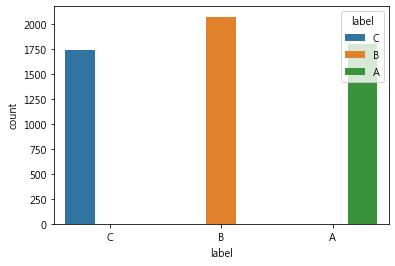

In [9]:
sns.countplot(label_Survey['label'], hue = label_Survey["label"])
sector = label_Survey.groupby('label')
sector.size()

## 三、顯示芒果圖片

## 四、製作標籤&資料集

In [10]:
csvfile = open('train.csv')
reader = csv.reader(csvfile)

In [11]:
# 讀取csv標籤
labels = []
for line in reader:
    tmp = [line[0],line[1]]
    # print tmp
    labels.append(tmp)
csvfile.close() 

In [12]:
# remove the first row
labels = labels[1:]
print("芒果圖片數量: ",len(labels))

芒果圖片數量:  5600


In [13]:
# 轉換圖片的標籤
for i in range(len(labels)):
    labels[i][1] = labels[i][1].replace("A","0")
    labels[i][1] = labels[i][1].replace("B","1")
    labels[i][1] = labels[i][1].replace("C","2")

In [14]:
# 隨機讀取圖片
a = 0
items= []
import random
for a in range(0,len(labels)):
    items.append(a)

In [15]:
# 製作訓練用資料集及標籤
X = []
y = []

for i in random.sample(items,round(len(items)/4)):
#     print(i)
    img = cv2.imread("C1-P1_Train/" + labels[i][0] )
    res = cv2.resize(img,(800,800),interpolation=cv2.INTER_LINEAR)
    res = img_to_array(res)
    X.append(res)    
    y.append(labels[i][1])

In [16]:
y_label_org = y

In [17]:
# 轉換至array的格式
X = np.array(X)
y = np.array(y)

In [18]:
# 轉換至float的格式
for i in range(len(X)):
    X[i] = X[i].astype('float32')

In [19]:
# 打映圖片訓練集的概況
# print(X[0])
print(type(X))
print(X.shape)

print(X[0].shape)
print(type(X[0]))

<class 'numpy.ndarray'>
(1400, 800, 800, 3)
(800, 800, 3)
<class 'numpy.ndarray'>


In [20]:
# 將標籤轉換至float格式
y = tf.strings.to_number(y, out_type=tf.float32)

In [21]:
# 打映圖片標籤的概況
print(y[0])
print(type(y[0]))

tf.Tensor(2.0, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [22]:
# 標籤進行one-hotencoding
y = np_utils.to_categorical(y, num_classes = 3)

In [23]:
y[0]

array([0., 0., 1.], dtype=float32)

## 五、製作訓練資料集

In [24]:
# 分配訓練集及測試集比例
x_train = X[:84]
y_train = y[:84]
x_test = X[84:]
y_test = y[84:]

In [25]:
y_train_label = [0.,0.,0.]

for i in range(0,len(y_train)):
    y_train_label = y_train[i] + y_train_label

In [26]:
y_test_label = [0.,0.,0.]

for i in range(0,len(y_test)):
    y_test_label = y_test[i] + y_test_label

In [27]:
y_train_label

array([28., 24., 32.])

In [28]:
y_test_label

array([403., 503., 410.])

In [29]:
print(type(x_train))
print(len(x_train))
print(x_train.shape)
print(type(x_train[0]))

<class 'numpy.ndarray'>
84
(84, 800, 800, 3)
<class 'numpy.ndarray'>


## 六、建立與訓練深度學習Model

In [30]:
# 建立深度學習CNN Model

model = tf.keras.Sequential()

model.add(layers.Conv2D(16,(3,3),
                 strides=(1,1),
                 input_shape=(800, 800, 3),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Conv2D(32,(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Conv2D(64,(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Flatten())

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(128,activation='relu'))


model.add(layers.Dropout(0.2))

model.add(layers.Dense(3,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 800, 800, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 800, 800, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 400, 400, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 400, 400, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 64)      0

history = model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [31]:
adam = optimizers.Adam(lr=5)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [32]:
# zca_whitening 對輸入數據施加ZCA白化
# rotation_range 數據提升時圖片隨機轉動的角度
# width_shift_range 圖片寬度的某個比例，數據提升時圖片水平偏移的幅度
# shear_range 剪切強度（逆時針方向的剪切變換角度）
# zoom_range 隨機縮放的幅度
# horizontal_flip 進行隨機水平翻轉
# fill_mode ‘constant’，‘nearest’，‘reflect’或‘wrap’之一，當進行變換時超出邊界的點將根據本參數給定的方法進行處理

datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [33]:
# 導入圖像增強參數
datagen.fit(x_train)
x_train = x_train/255
x_test = x_test/255
print('rescale！done!')

rescale！done!


In [34]:
# 設定超參數HyperParameters 
batch_size =  4
epochs = 10

In [35]:
# 檔名設定
file_name = str(epochs)+'_'+str(batch_size)

In [36]:
# 加入EarlyStopping以及Tensorboard等回調函數
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

## 柒、繪製Model學習成效

In [38]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

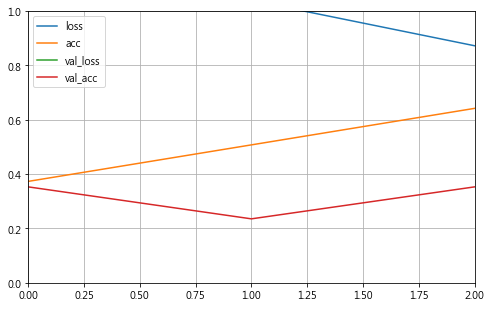

In [39]:
plot_learning_curves(history)

## 捌、推測圖片

In [40]:
test_mango_dir = os.path.join("C1-P1_Dev")
test_mango_fnames = os.listdir(test_mango_dir)

In [41]:
test_mango_fnames[0]

'00027.jpg'

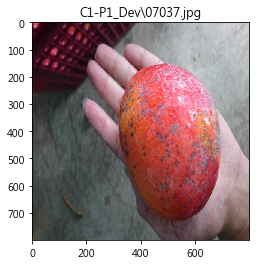

In [42]:
img_files = [os.path.join(test_mango_dir,f) for f in test_mango_fnames]
img_path = random.choice(img_files)

# 讀入待測試圖像並秀出
img = load_img(img_path, target_size=(800, 800))  # this is a PIL image
plt.title(img_path)
plt.grid(False)
plt.imshow(img)

In [43]:
labels = ['等級A','等級B',"等級C"]

In [44]:
# 將圖像轉成模型可分析格式(800x800x3, float32)
x = img_to_array(img)  # Numpy array with shape (800, 800, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 800, 800, 3)
x /= 255 # Rescale by 1/255

start = time.time() # 啟動計時器
result = model.predict(x) # 對輸入圖像進行推論(預測)
finish = time.time() # 結束計時器

pred = result.argmax(axis=1)[0]
pred_prob = result[0][pred]

print("Result = %f" %pred_prob) # 印出結果可能機率值(0.0 ~ 1.0)
print("Test time :%f second." %(finish-start)) # 印出推論時間

# 設定分類門檻值並印出推論結果
print("有 {:.2f}% 機率為{}".format(pred_prob * 100,labels[pred])) # 印出推論時間

Result = 0.351751
Test time :0.125582 second.
有 35.18% 機率為等級C


## 玖、測試集預測準確度

In [45]:
# 測試集標籤預測
y_pred = model.predict(x_test)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,3,800,800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d/Relu (defined at C:\Users\forever\Anaconda3\envs\ken2\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_2032]

Function call stack:
distributed_function


In [ ]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

In [ ]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
print(len(predict_label))

In [ ]:
# 模型原標籤
true_label = y_label_org[84:]
true_label = np.array(true_label)
print(true_label)
print(len(true_label))

In [ ]:
# 模型預測後的標籤
predictions = model.predict_classes(x_test)
print(predictions)
print(len(predictions))

In [ ]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

In [ ]:
# 儲存模型相關參數
# model.save('h5/'+file_name+'.h5')